<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/load_NextFrame200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
seq = keras.models.load_model('drive/My Drive/tfm/learn/NextFrame/200epochModel.h5')
seq

In [4]:
# UTIL FUNCTIONS

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies


def row_n_imageshow(imgs, titles=None):
  n = len(imgs)
  fig = plt.figure(figsize=(5*n, 5))

  for i, img in enumerate(imgs):
    ax = fig.add_subplot(1, n, i+1)
    if titles and len(titles) > i and titles[i]:
      ax.text(**titles[i])
    plt.imshow(img)


def plot_performance_evaluation(noisy_track, shifted_track, pred_track, n_decimals=4):
  disc_pred_track = (pred_track> 0.5).astype(float)

  for i in range(min(len(pred_track), len(noisy_track))):
    disc_shifted_frame = (shifted_track[i,::,::,0]>0.5)
    pixel_performance = np.logical_not(np.logical_xor(disc_pred_track[i,::,::,0], disc_shifted_frame)).astype(float)
    accuracy = round(pixel_performance.sum()/pixel_performance.size, n_decimals)
    # index -> reality, columns -> prediction
    confusionDF = pd.DataFrame(confusion_matrix(disc_shifted_frame.astype(float).flatten(), disc_pred_track[i,::,::,0].flatten()), index=[0,1], columns=[0,1])
    precision = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[0, 1]), n_decimals)
    recall = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[1, 0]), n_decimals)
    f1 = round(2 * (precision*recall)/(precision+recall), n_decimals)

    txts = [{'x': 1, 'y': 3, 's':'Predictions !', 'fontsize':20, 'color':'w'},
          {'x': 1, 'y': 3, 's':'Discrete Predictions !', 'fontsize':20, 'color':'w'},
          {'x': 1, 'y': 3, 's':'Ground truth (shifted)', 'fontsize':20},
          {'x': 1, 'y': 3, 's':'Original frame', 'fontsize':20},
          {'x': 1, 'y': 3, 's':f'Accuracy {accuracy}, f1: {f1}\nprecision: {precision}, recall: {recall}', 'fontsize':10}]
    row_n_imageshow([pred_track[i, ::, ::, 0],
                     disc_pred_track[i, ::, ::, 0], 
                     (shifted_track[i,::,::,0]>0.5).astype(float),
                     noisy_track[i,::,::,0],
                     pixel_performance], titles=txts)

# **Predict whole half track**
[ frame0, ..., frame6 ] -prediction-> [ frame0, ..., frame6, pred_frame7 ]

[ frame0, ..., frame6, pred_frame7] -prediction-> [ frame0, ..., frame6, pred_frame7, pred_frame8 ]

...

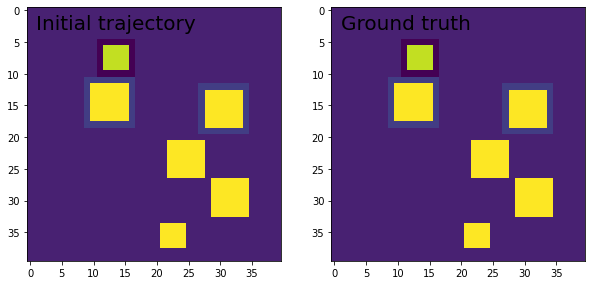

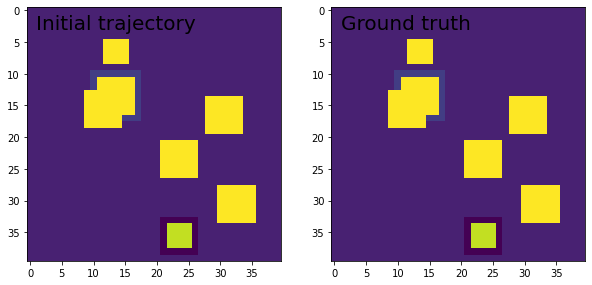

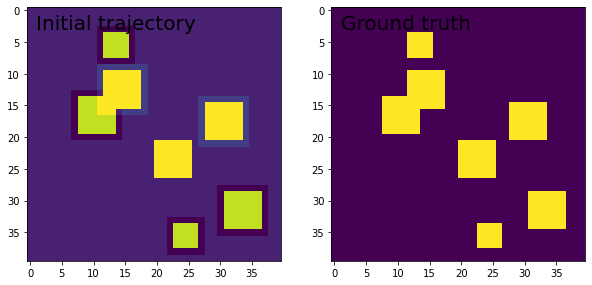

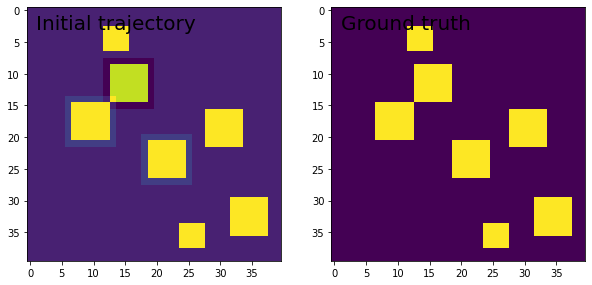

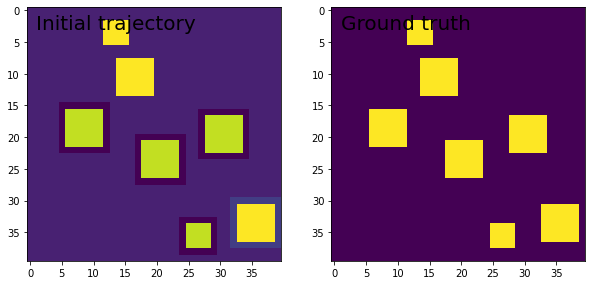

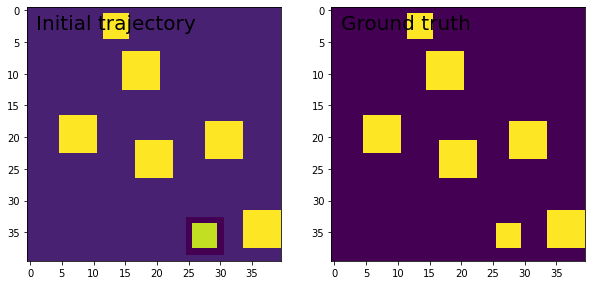

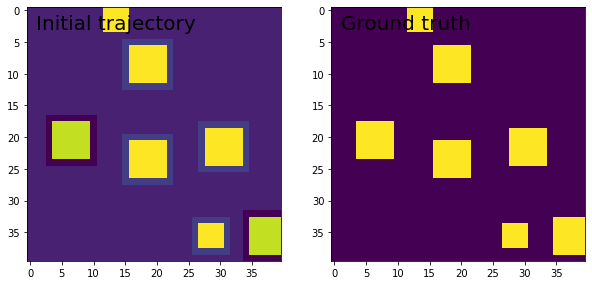

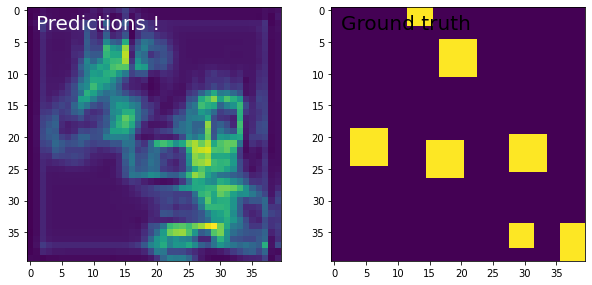

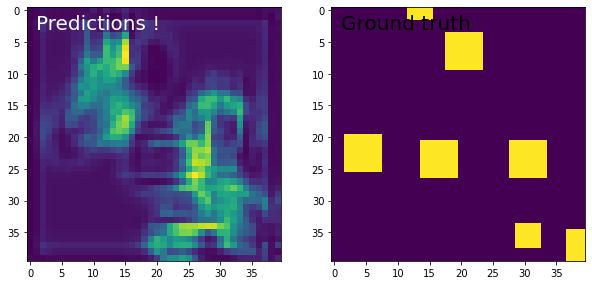

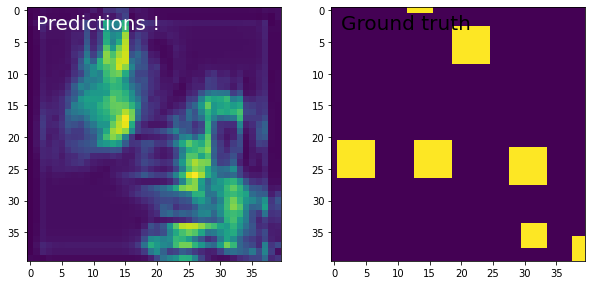

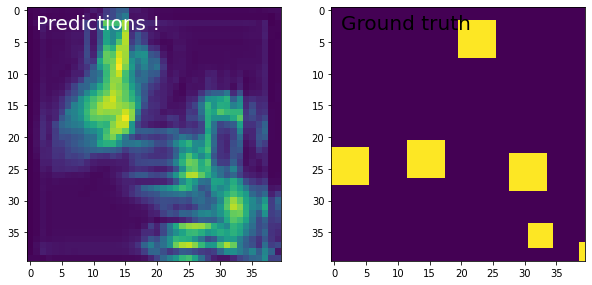

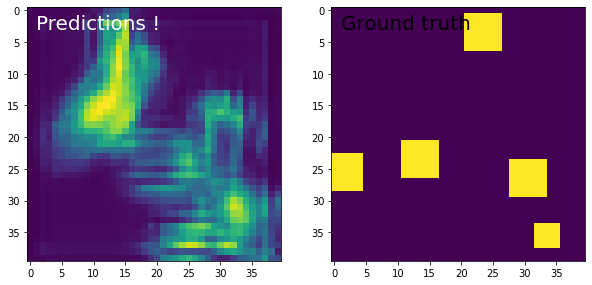

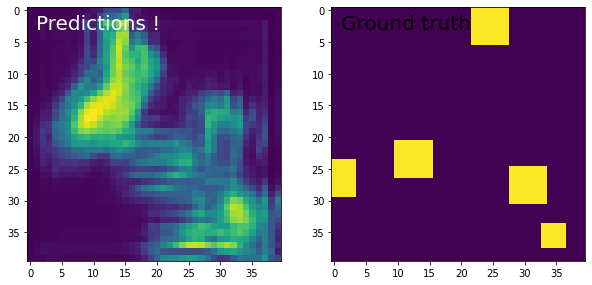

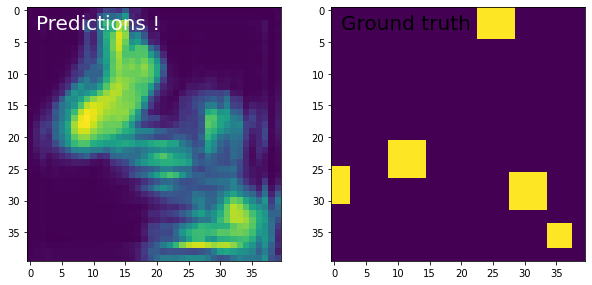

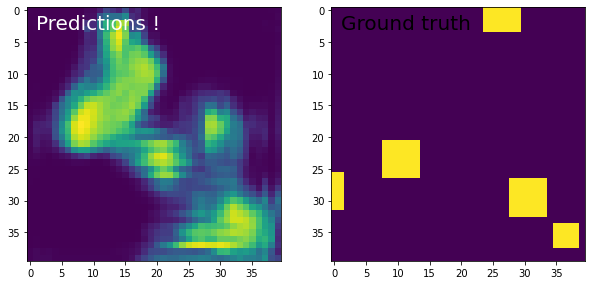

In [11]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)

movie_index = 1004
track = noisy_movies[movie_index][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    # plt.savefig("%i_animate.png" % (i + 1))


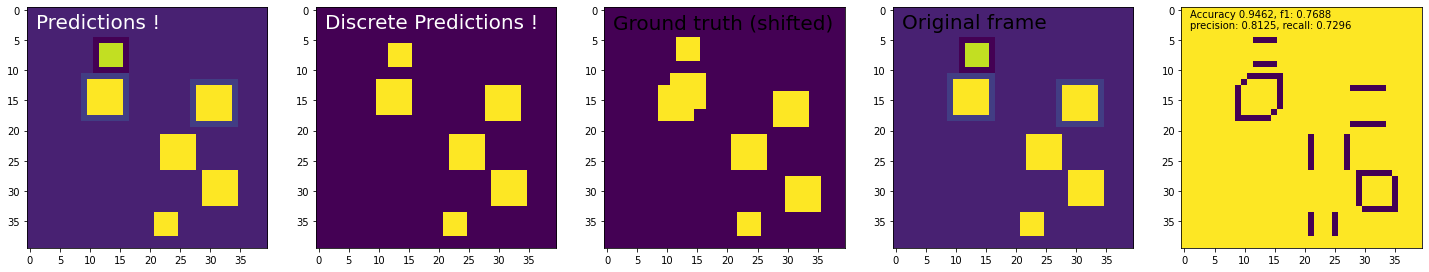

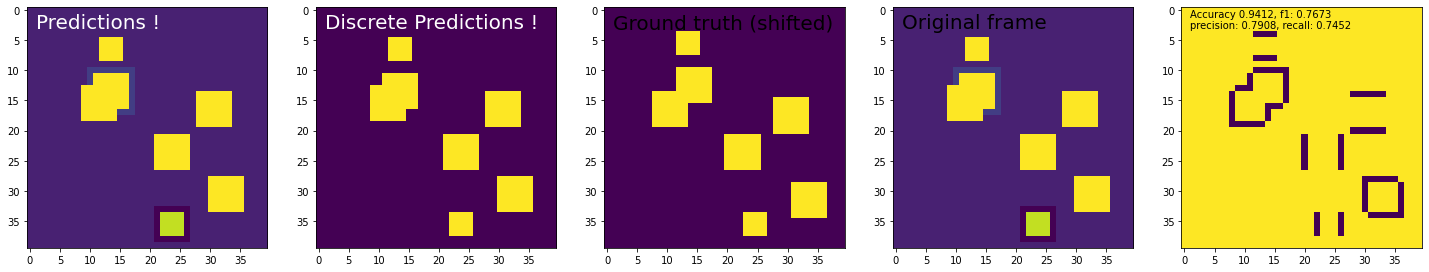

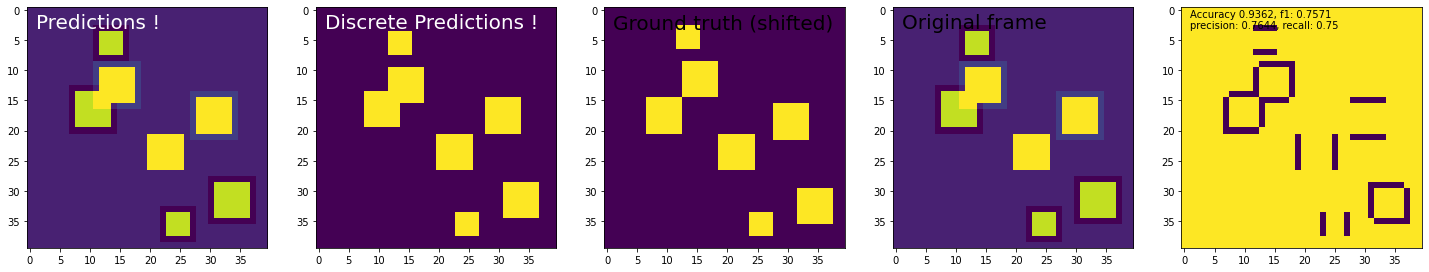

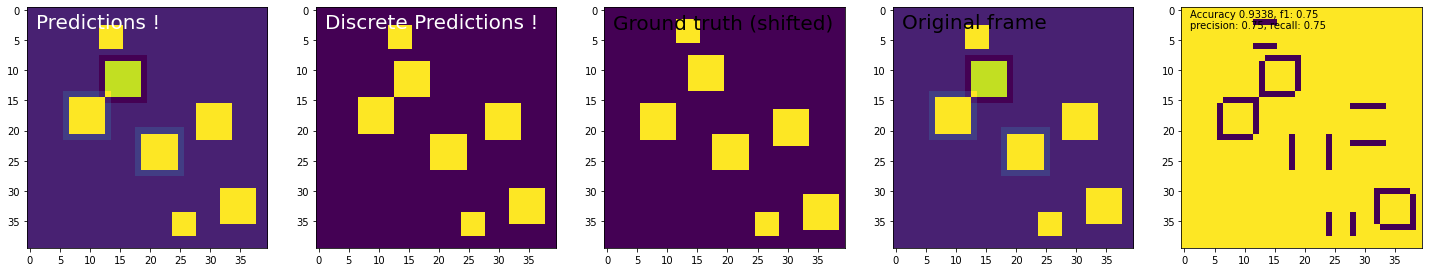

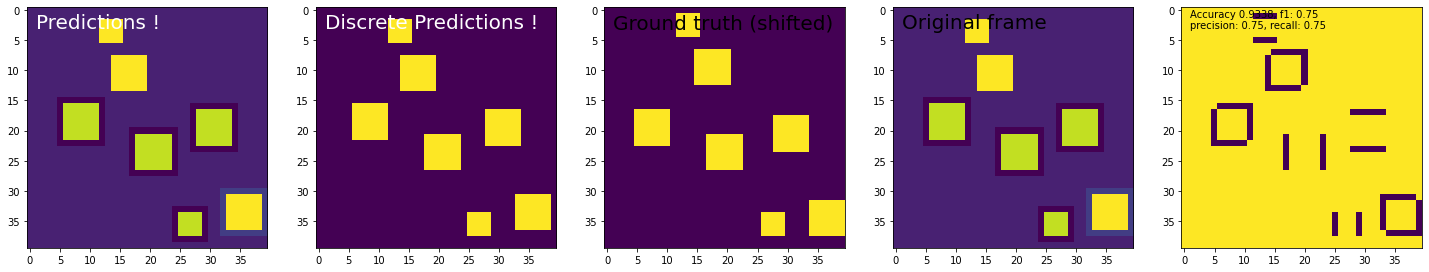

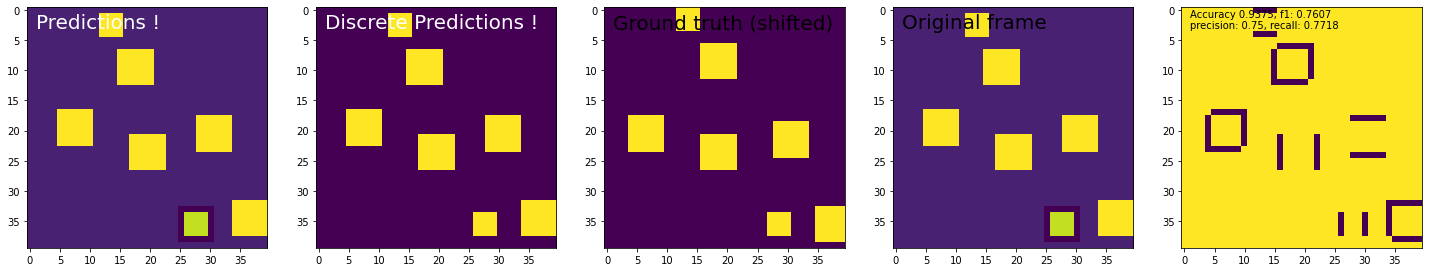

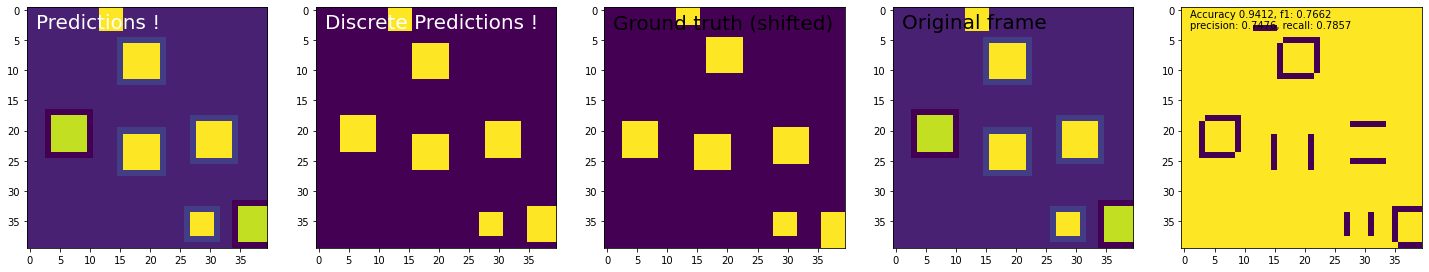

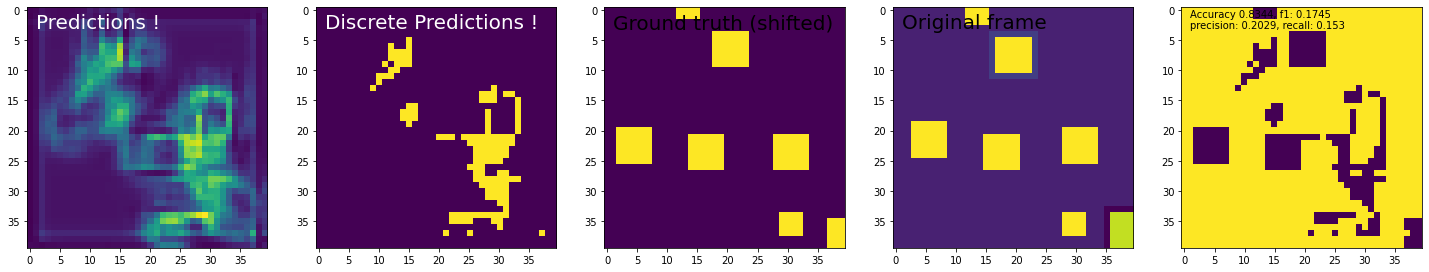

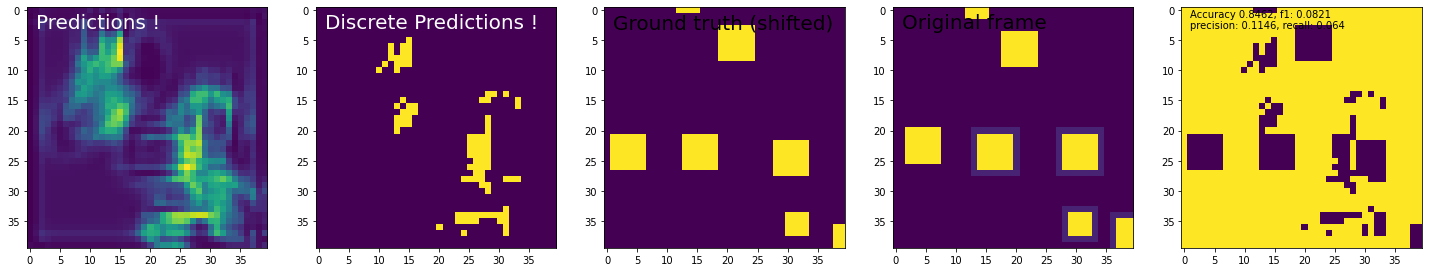

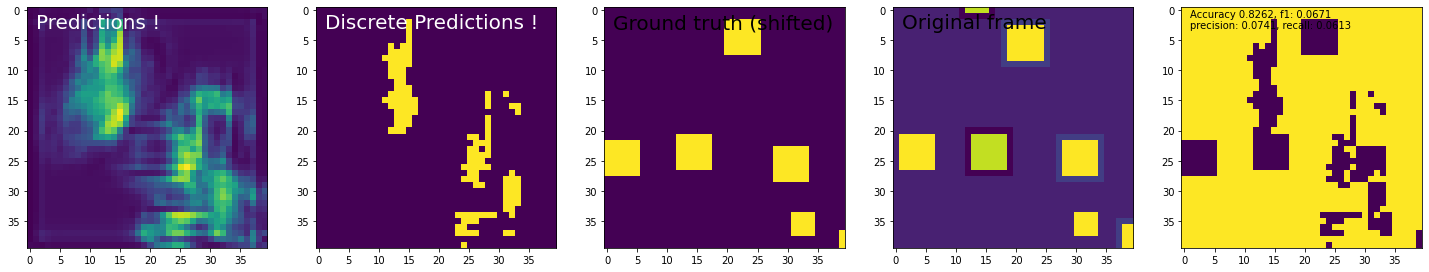

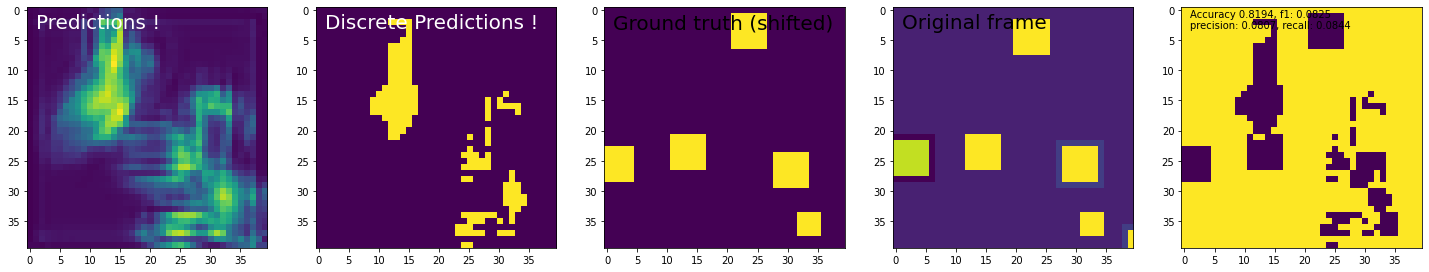

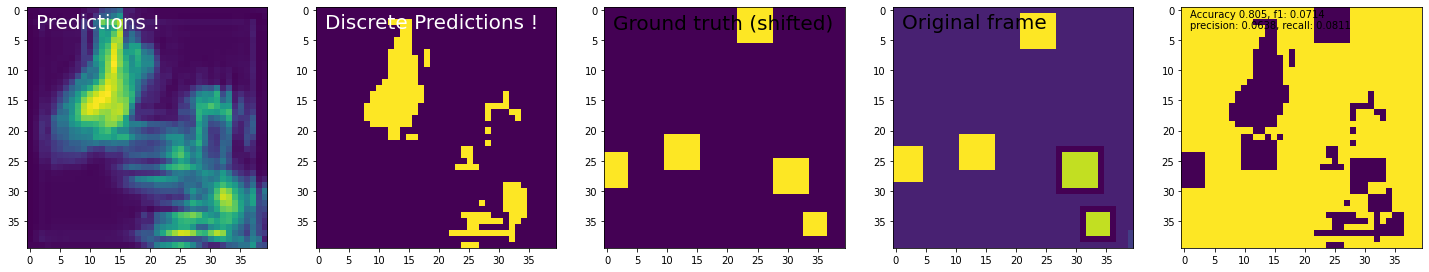

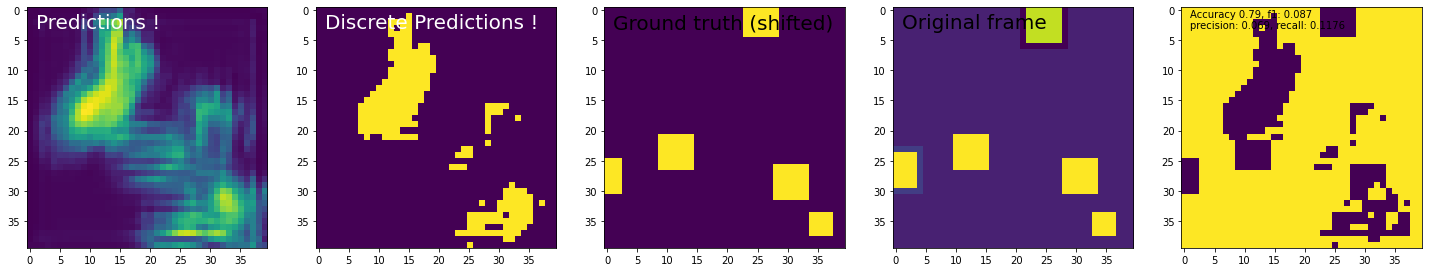

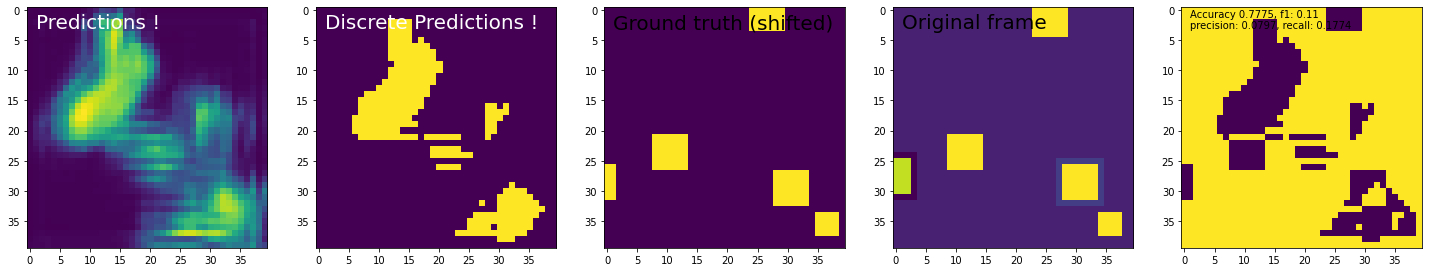

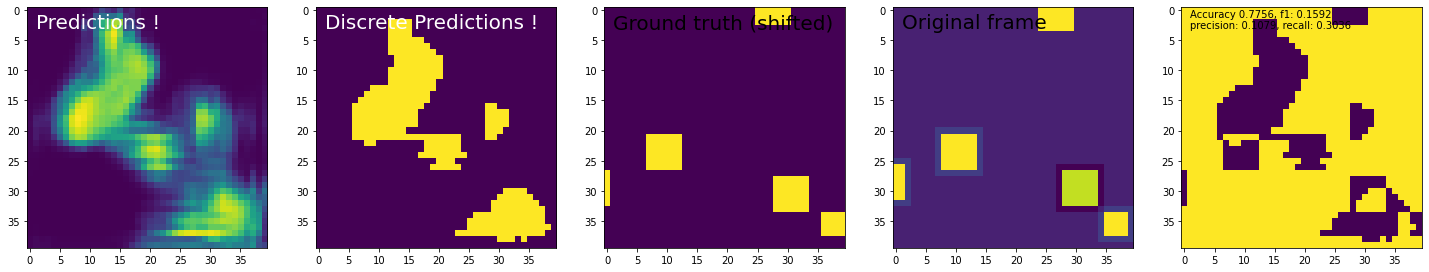

In [12]:
plot_performance_evaluation(noisy_movies[movie_index], shifted_movies[movie_index], track)

In [ ]:
def two_line_plots(data, datb):
  fig = plt.figure()
  ax = fig.add_subplot(121)
  ax.plot(data.flatten())
  ax = fig.add_subplot(122)
  ax.plot(datb.flatten())

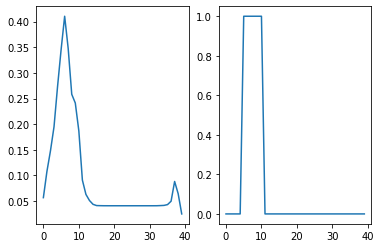

In [ ]:
two_line_plots(track[8][:,3], track2[8][:,3])

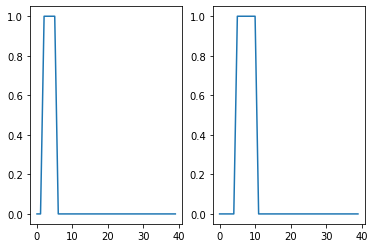

In [ ]:
auxtrack = (track>0.5).astype(float)
two_line_plots(auxtrack[8][:,1], track2[8][:,1])
# list(enumerate(np.logical_and(auxtrack[8].any(axis=0),track2[8].any(axis=0))))

# **Predict frame by frame shifted movie**
### Predict using all 15 frames
[ frame0, ..., frame14 ] -predict-> [ pred_frame1, ..., pred_frame15 ]

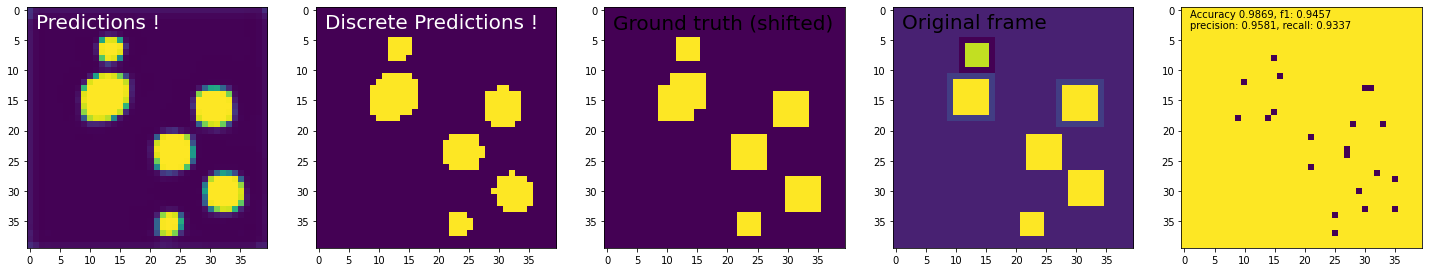

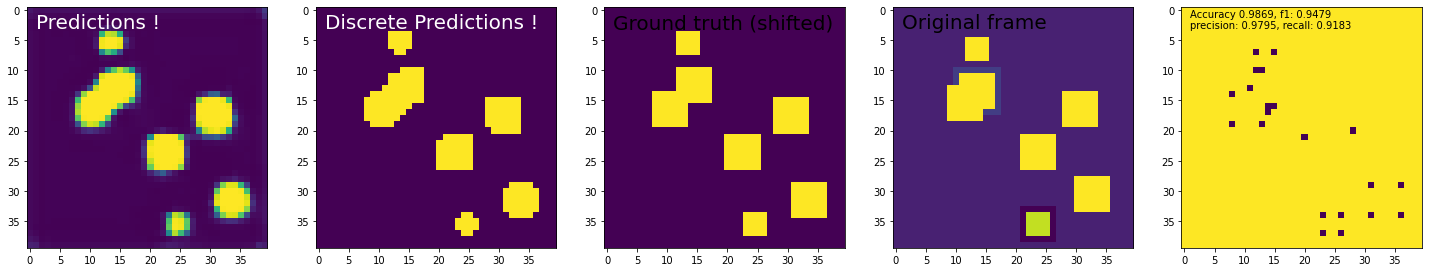

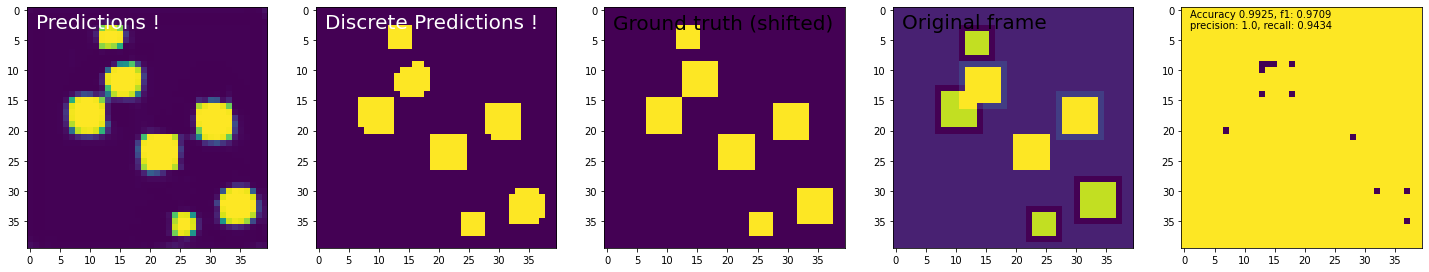

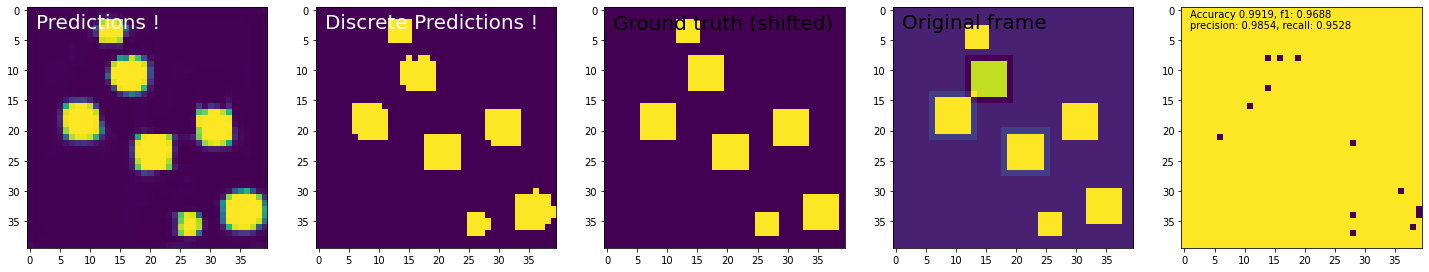

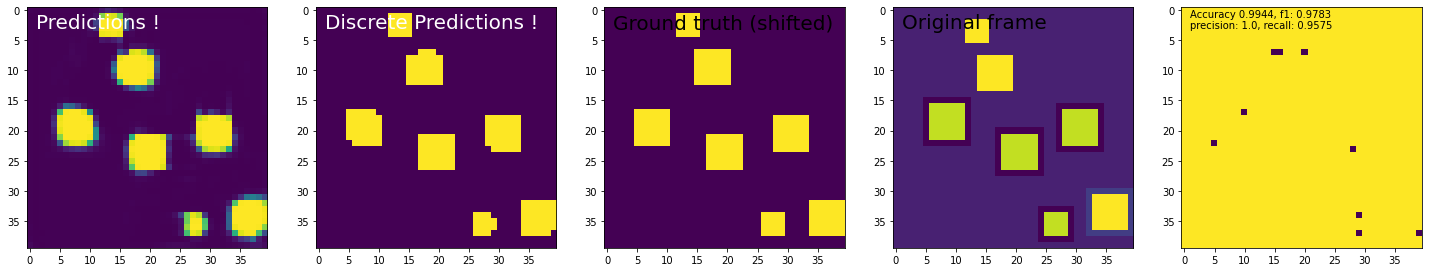

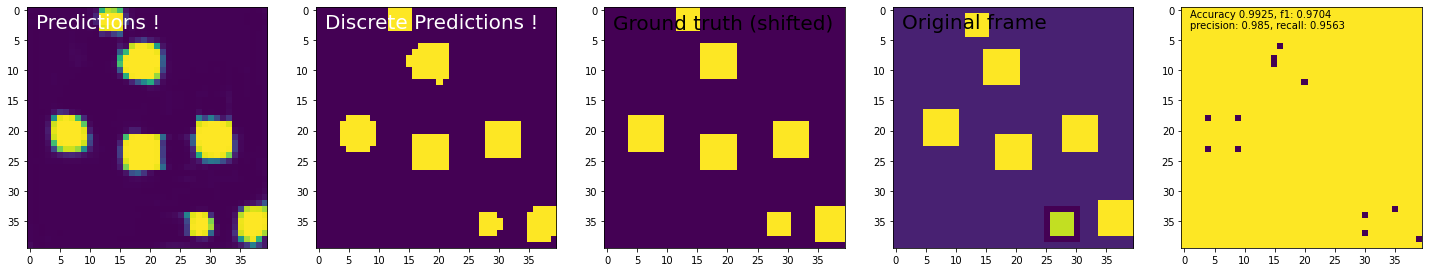

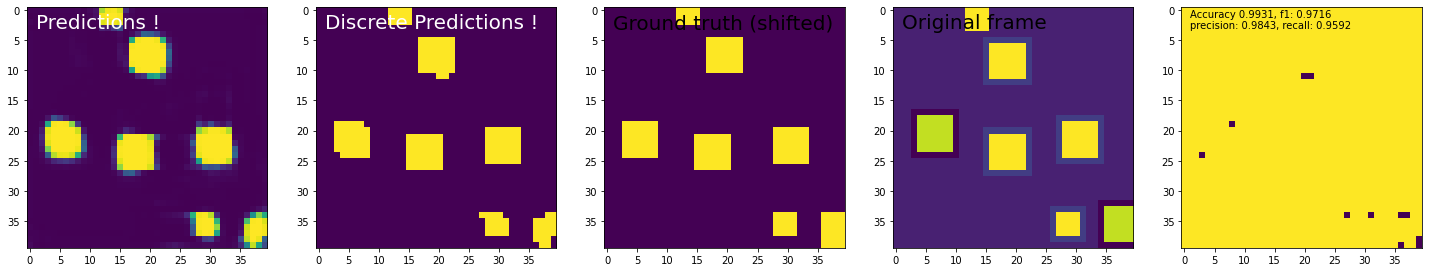

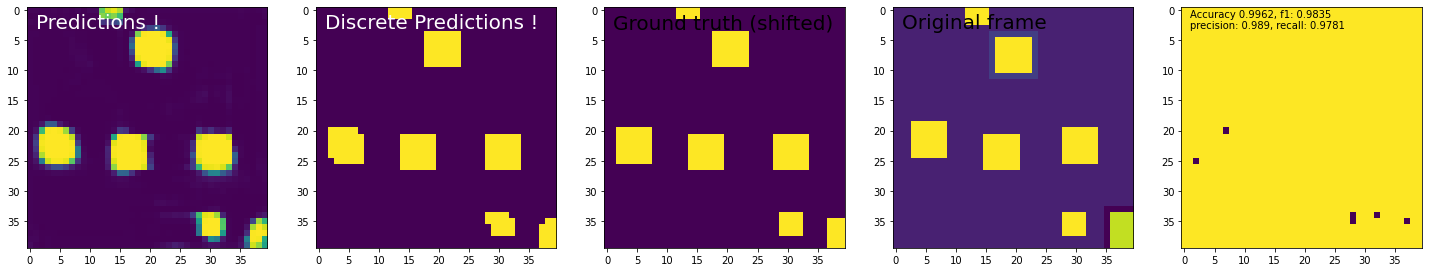

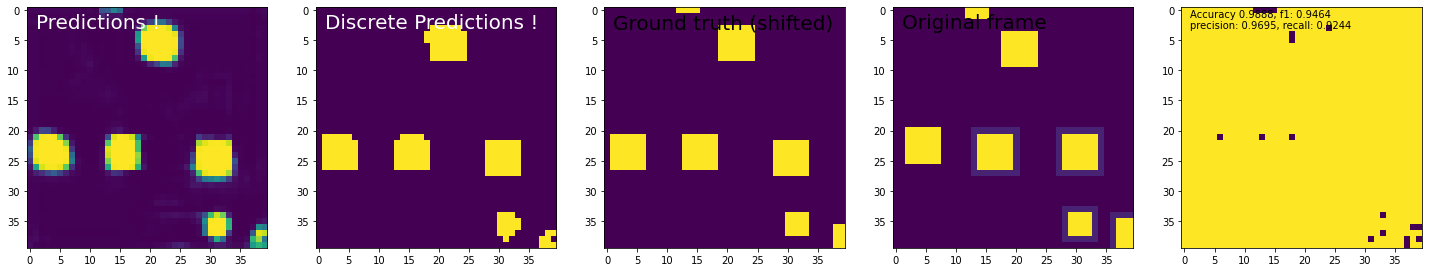

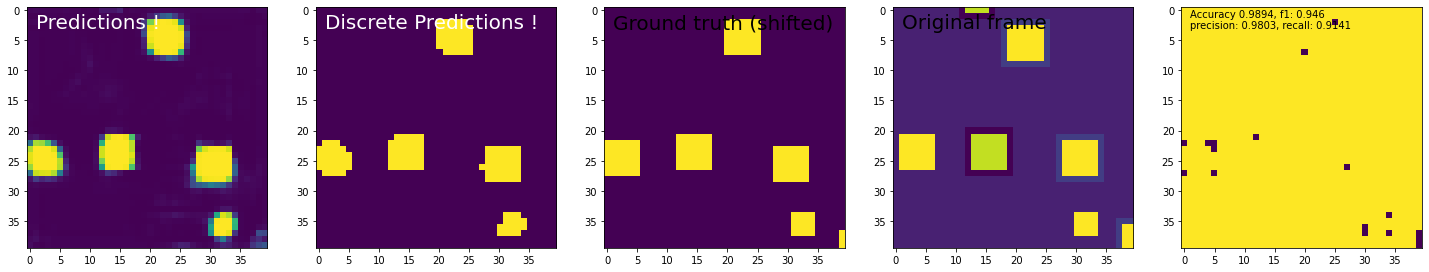

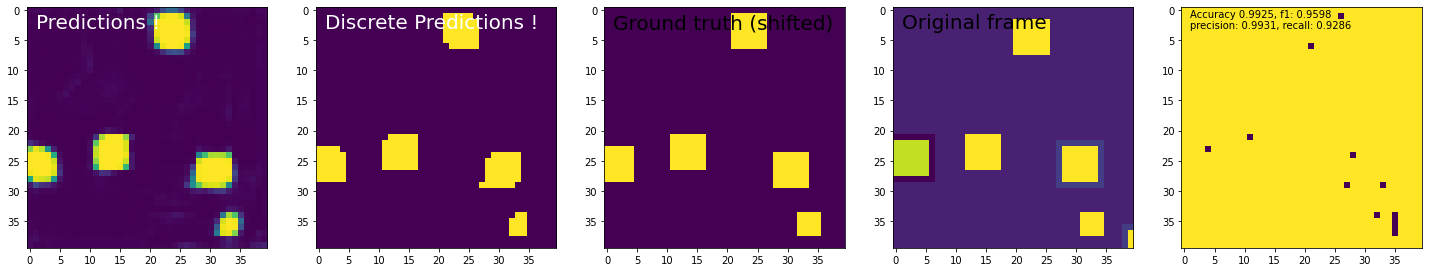

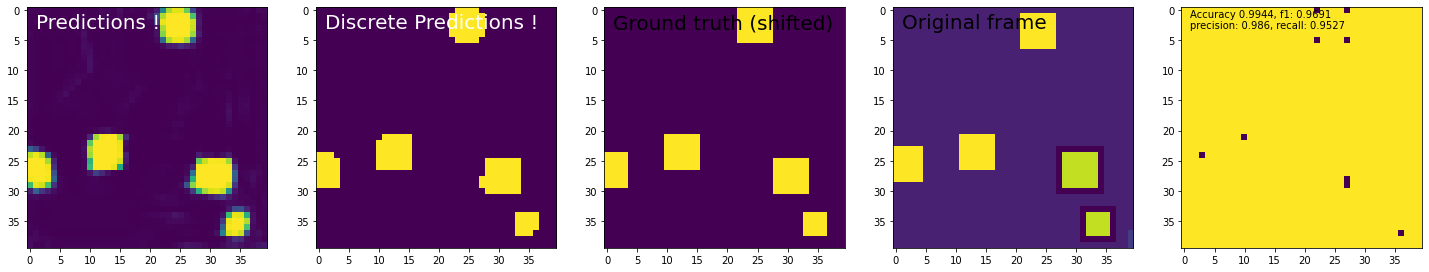

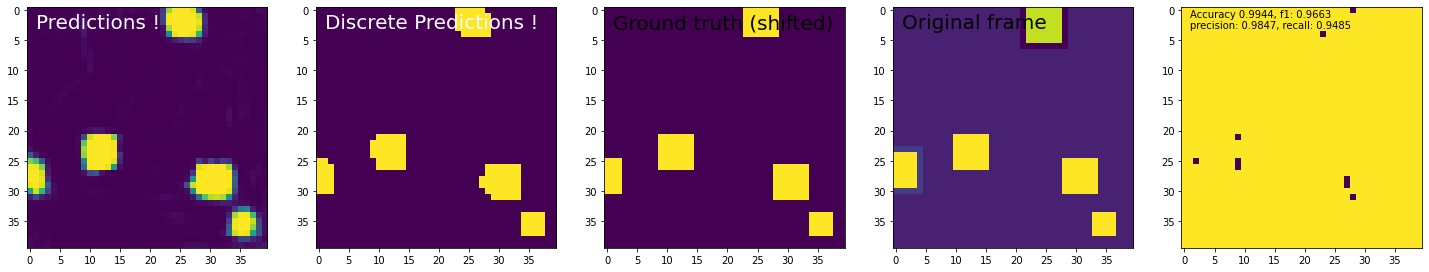

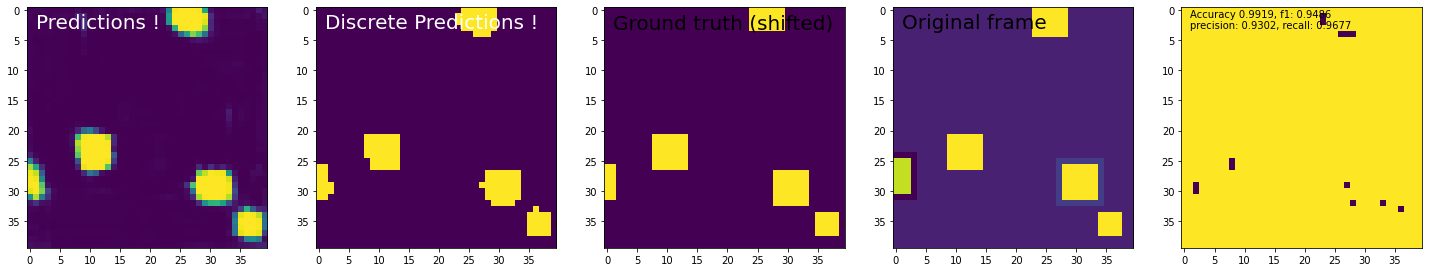

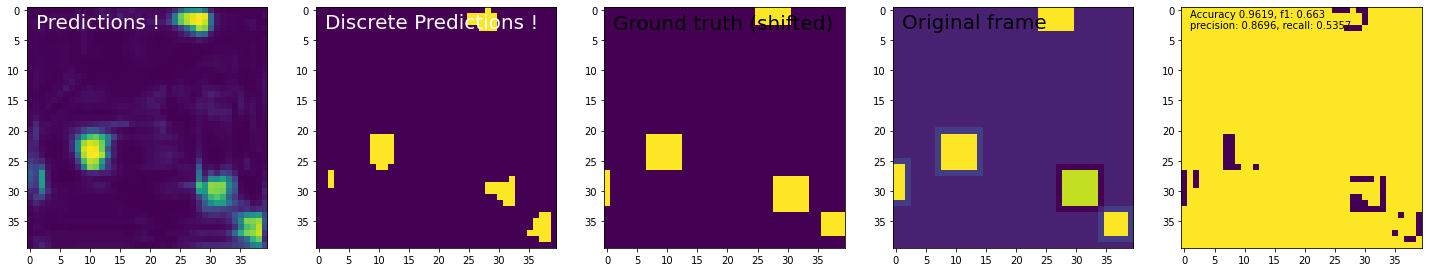

In [13]:
noisy_track = noisy_movies[movie_index]
shifted_track = shifted_movies[movie_index]
pred_track = seq.predict(noisy_track[np.newaxis, ::, ::, ::, ::])[0]


plot_performance_evaluation(noisy_track, shifted_track, pred_track)

,0,1
0,1479,9
1,52,60


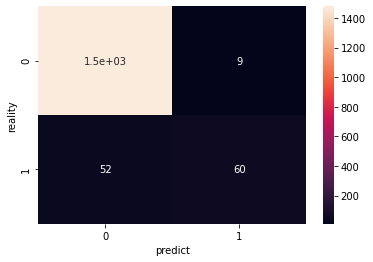

In [15]:
df = pd.DataFrame(confusion_matrix((shifted_track[i,::,::,0]>0.5).flatten(), (pred_track[i,::,::,0]>0.5).flatten()), index=[0,1], columns=[0,1])
sn.heatmap(df, annot=True)
plt.xlabel('predict')
plt.ylabel('reality')
df

### Predict using just 7 frames
[ frame0, ..., frame6 ] -predict-> [ pred_frame1, ..., pred_frame7 ]

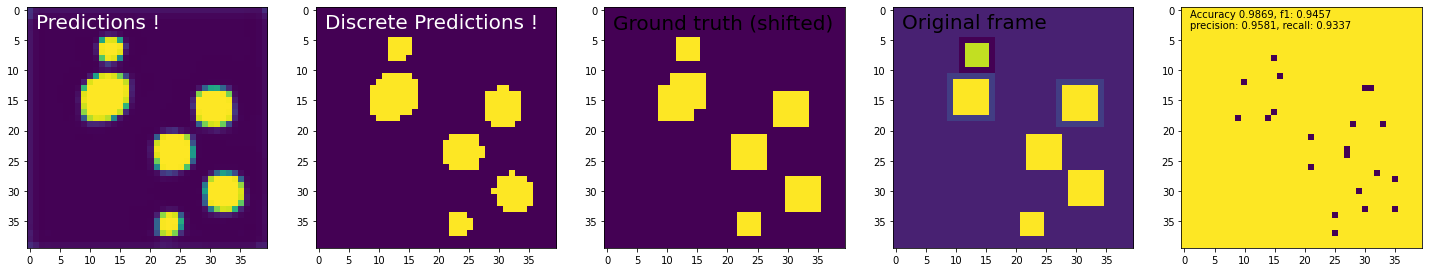

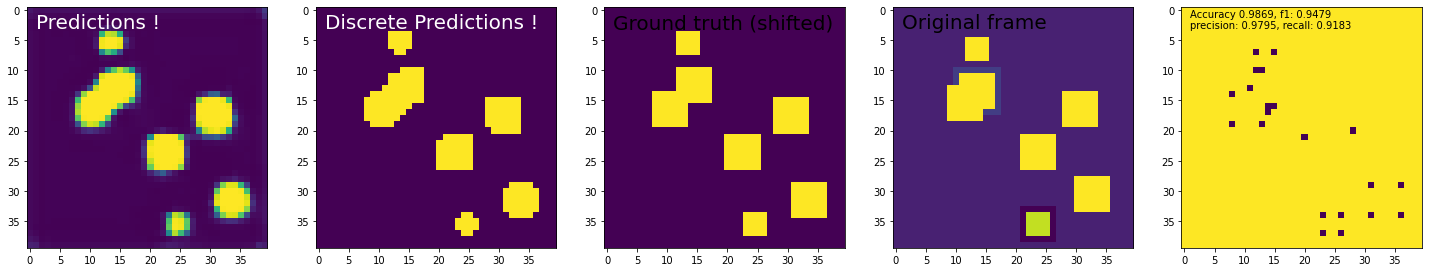

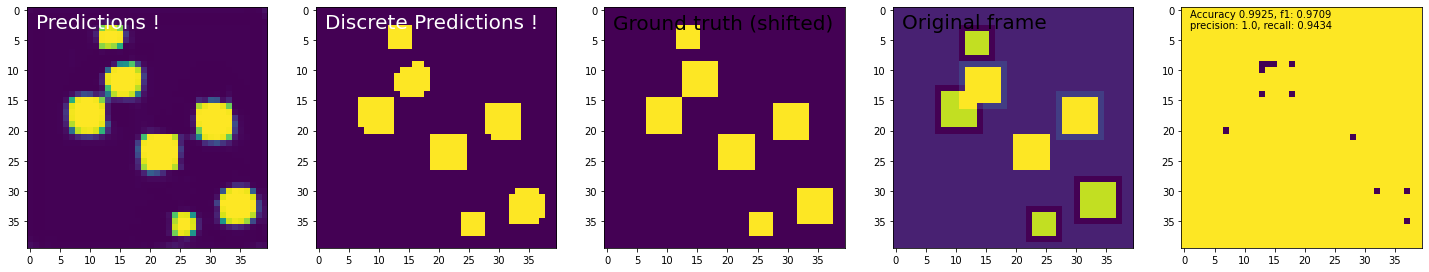

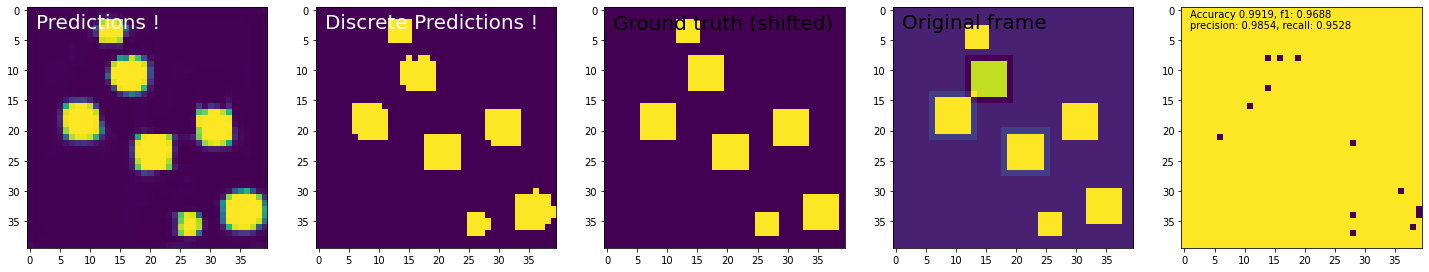

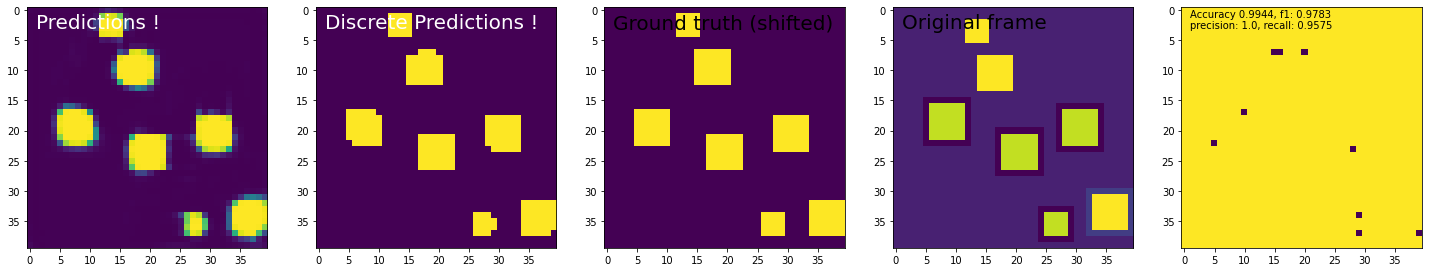

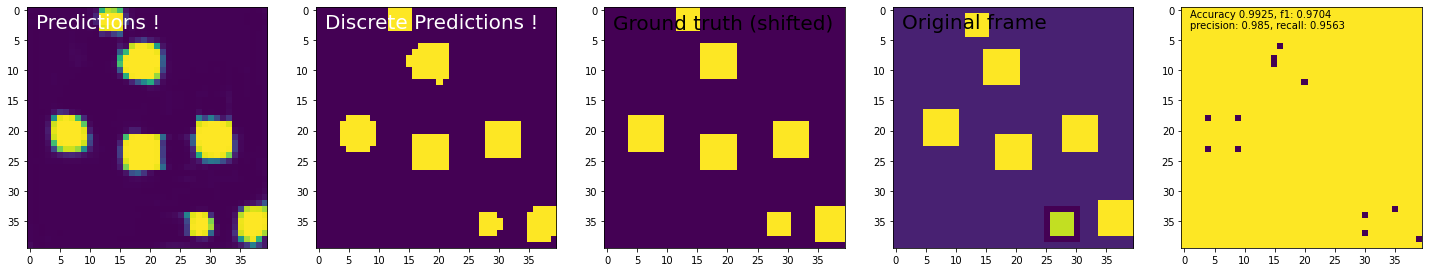

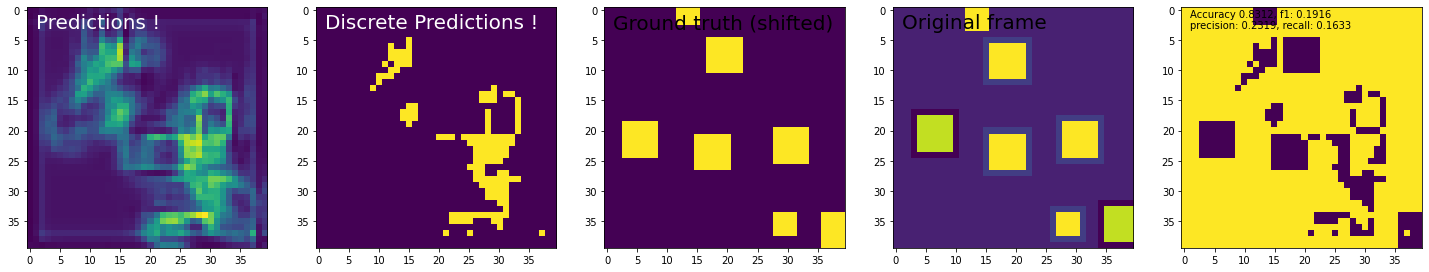

In [16]:
noisy_track = noisy_movies[movie_index][:7]
shifted_track = shifted_movies[movie_index][:7]
pred_track = seq.predict(noisy_track[np.newaxis, ::, ::, ::, ::])[0]


plot_performance_evaluation(noisy_track, shifted_track, pred_track)